# Binary classification data

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split, TensorDataset

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Ratios for later use:  0.2 0.2 0.6


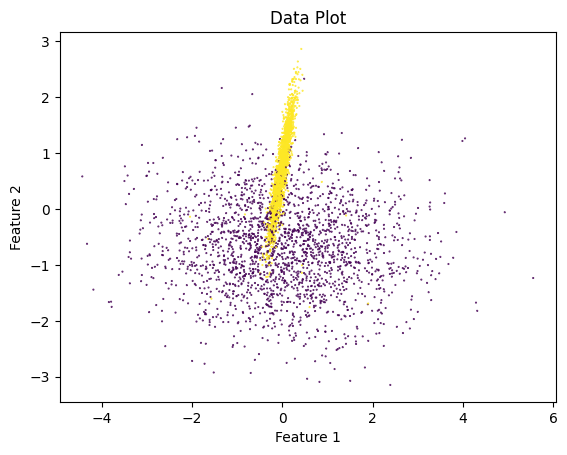

Shape of sets:  (819, 2) (819,) (819, 2) (819,) (2458, 2) (2458,)
Len of loaders:  819 819 2458


In [2]:
def generate_dataset(seed=42):
    """
    Parameters:
        difficulty (str): "easy", "medium", or "hard"
    """
    # Default parameters
    params = {
        "n_samples": 4 * 1024,
        "n_features": 2,
        "n_classes": 2,
        "n_informative": 2,
        "n_redundant": 0,
        "n_repeated": 0,
        "hypercube": True,
        "shift": 0,
        "scale": 1.0,
        "shuffle": True,
        "random_state": seed
    }
    params.update({
        "n_clusters_per_class": 1,
        "weights": [0.5, 0.5],
        "flip_y": 0.01,  # Less aleatoric noise
        "class_sep": 0.9
    })

    # Generate dataset
    X, y = make_classification(**params)

    return X, y


def create_loaders(X, y, batch_size, test_size, val_size, seed):
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    plt.scatter(X[:, 0], X[:, 1], marker='x', c=y, facecolors='none', alpha=0.8, s=0.3)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Data Plot")
    plt.show()

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=seed)

    # Create DataLoaders (no worker_init_fn needed)
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long()),
                              batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long()),
                            batch_size=batch_size, shuffle=False)

    test_loader = DataLoader(TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long()),
                             batch_size=batch_size, shuffle=False)

    print("Shape of sets: ", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
    print("Len of loaders: ", len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

    return train_loader, val_loader, test_loader, X_train, y_train, X_val, y_val, X_test, y_test



# corresponds to "easy"
batch_size = 32 * 4
test_size = 0.6
val_size = 0.5  #20%
train_ratio = (1 - test_size)*(1 - val_size)
val_ratio = (1 - test_size)*val_size
test_ratio = test_size
print("Ratios for later use: ", train_ratio, val_ratio, test_ratio)
data_seed = 42

X, y = generate_dataset(data_seed)
(train_loader, val_loader, test_loader,
  X_train, y_train, X_val, y_val, X_test, y_test) = create_loaders(X, y, batch_size, test_size, val_size, data_seed)


### Load models

In [3]:
import sys
# locally
#sys.path.append('../src')

# for colab
from google.colab import drive
drive.mount('/content/drive')

# Append your folder's path to sys.path
sys.path.append('/content/drive/MyDrive/Thesis_REMOVE/')

from members import SimpleNN
from deep_ensemble import DeepEnsemble
from calibrator import Calibrator

from plotting import plot_metrics, plot_confusion_matrix

Mounted at /content/drive


Early stopping triggered at epoch 30.


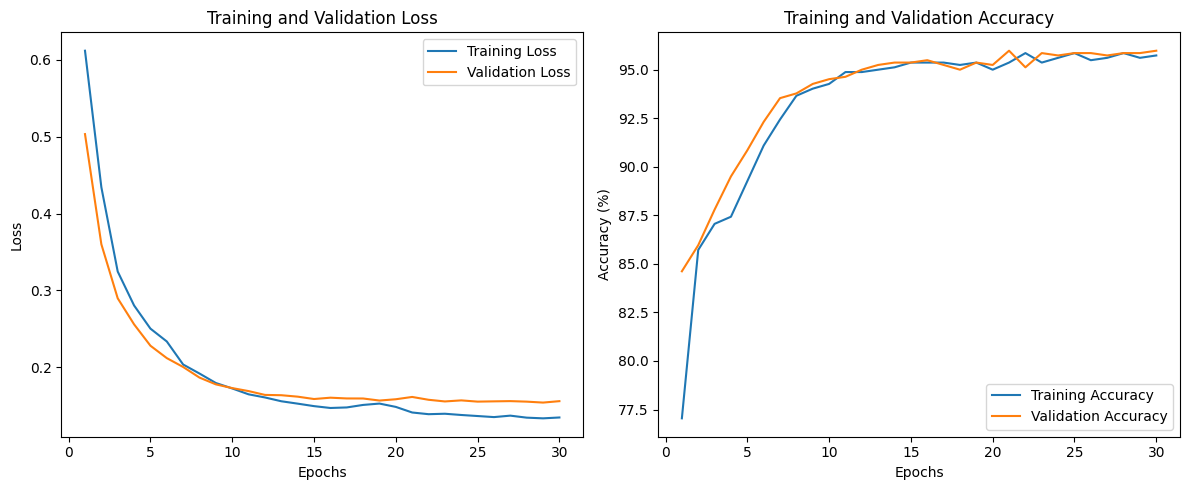

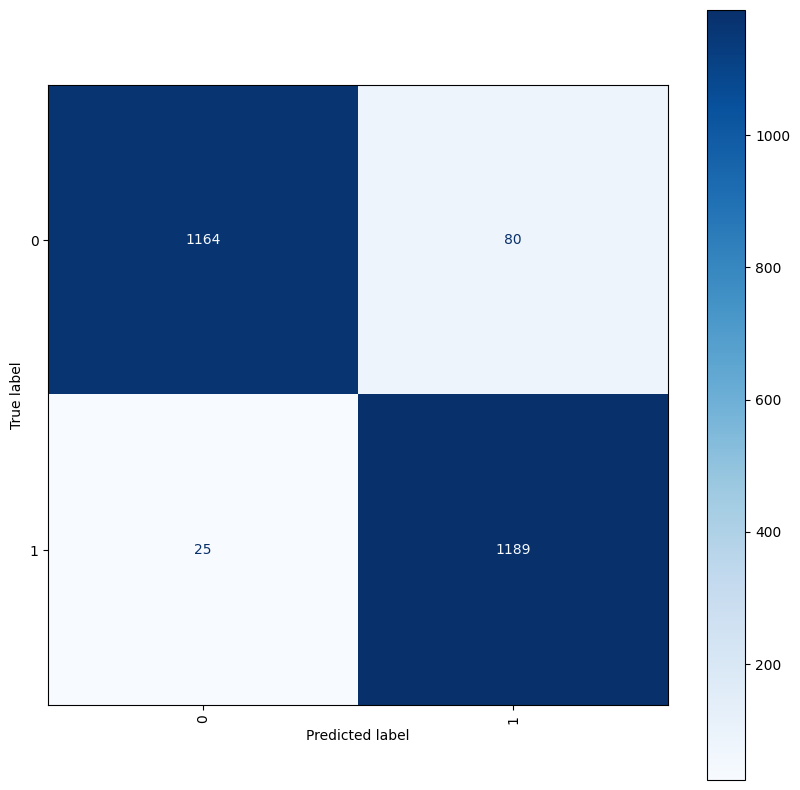

In [4]:
input_shape = X_train.shape[1]
output_shape = len(np.unique(y_train))

lr = 1e-3
criterion = nn.CrossEntropyLoss()
num_epochs = 30
patience = 5
min_delta = 1e-6

snn = SimpleNN(input_shape, output_shape)
optimizer = torch.optim.Adam(snn.parameters(), lr=lr)
train_losses, train_accuracies, val_losses, val_accuracies = snn.train_model(train_loader, val_loader, criterion, optimizer,
                                                                            num_epochs, True,
                                                                             patience, min_delta)

# Plot the training and validation metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, len(val_losses))

# Evluating the model
class_names = [str(i) for i in range(2)]
plot_confusion_matrix(snn, test_loader, class_names)

DeepEnsemble(
  (models): ModuleList(
    (0-4): 5 x SimpleNN(
      (fc1): Linear(in_features=2, out_features=32, bias=True)
      (fc2): Linear(in_features=32, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=128, bias=True)
      (fc4): Linear(in_features=128, out_features=2, bias=True)
    )
  )
)
All models have stopped. Ending training at epoch 30.


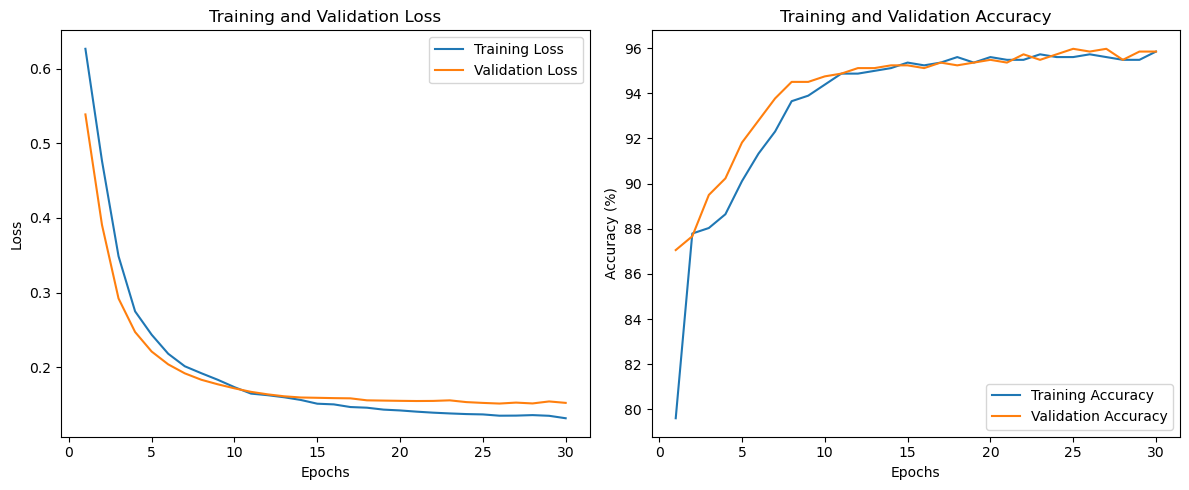

Validation accuracy:  95.84859584859585


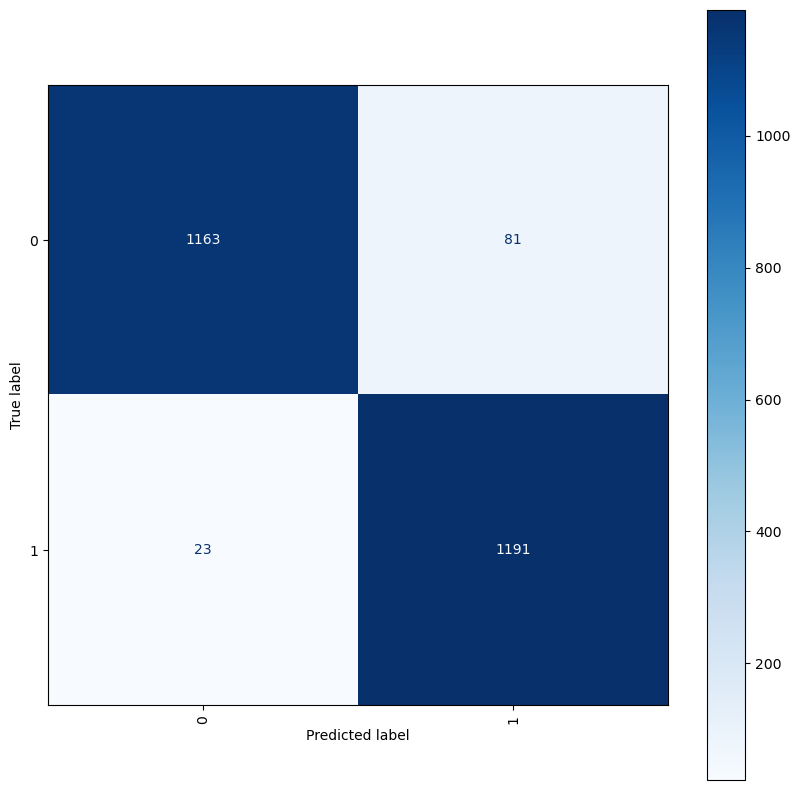

In [ ]:
epsilon = 0.1
weight_decay = 1e-5

#instnatiate the deep ensemble
ensemble_model = DeepEnsemble( num_models=5, model_class=SimpleNN, lr=lr, weight_decay=weight_decay,
                             output_shape = output_shape , input_shape = input_shape  # Passed as keyword argument to SimpleClassifier
                             )
print(ensemble_model)

de_train_results = ensemble_model.train_model(train_loader, val_loader, criterion, num_epochs, epsilon,
                                              adversarial_training=False, early_stopping=True,   # NOTE false
                                              patience=5, min_delta=1e-6)
#plot the results
plot_metrics(de_train_results['train_losses'], de_train_results['val_losses'],
             de_train_results['train_accuracies'],  de_train_results['val_accuracies'], len(de_train_results['train_losses']))
print("Validation accuracy: ", de_train_results['val_accuracies'][-1])
plot_confusion_matrix(ensemble_model, test_loader, class_names=class_names)

# Full pipeline

### Check for a proper grid

1. With early stopping
2. Without early stopping

### Early stopping

In [ ]:
num_seeds = 25

# some duplicatese
lr = 1e-3
weight_decay = 5e-4
num_epochs = 50
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.0      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_ratio}_{val_ratio}_{test_ratio}_{batch_size}",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    model_member = SimpleNN(input_shape, output_shape)
    optimizer = torch.optim.Adam(model_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = model_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=True,                                                 # NOTE true
                               patience=patience, min_delta=min_delta)

    model_val = model_member.predict(val_loader)
    model_test = model_member.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(model_val['nll']),
        "NLL Test": np.mean(model_test['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=SimpleNN, lr = lr, weight_decay=weight_decay,
                                 input_shape=input_shape, output_shape=output_shape)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=False,                      # NOTE false
                                  early_stopping=True,                             # NOTE true
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 300, 200)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 10, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"])
        })



# NOTE naming based of data
df_results_no_AT = pd.DataFrame(results_list)


df_mean = df_results_no_AT.groupby(['Model'])[['NLL Val', 'NLL Test', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean


=== Running experiment with MODEL SEED = 25 ===
Early stopping triggered at epoch 30.
Early stopping triggered for model 0 at epoch 26.
Early stopping triggered for model 2 at epoch 26.
Early stopping triggered for model 3 at epoch 26.
Early stopping triggered for model 4 at epoch 26.
Early stopping triggered for model 1 at epoch 35.
All models have stopped. Ending training at epoch 35.
Calibrating using method: pure_logits
Best parameters: {'c1': 0.8545454545454545, 'c2': 2.4141414141414144, 'epi_scalar': 1, 'nll_val': 0.13857120275497437}
Calibrating using method: convex_comb
Best parameters: {'c1': 0.8727272727272728, 'c2': 3.8383838383838382, 'epi_scalar': 1, 'nll_val': 0.14120803773403168}
Calibrating using method: convex_comb_no_exp
Best parameters: {'c1': 0.8727272727272728, 'c2': 40.7035175879397, 'epi_scalar': 1, 'nll_val': 0.14429916441440582}
Calibrating using method: convex_comb_global
Best parameters: {'c1': 0.9090909090909092, 'c2': 0.0, 'epi_scalar': 1, 'nll_val': 0.144

,NLL Val,NLL Test,C1,C2,Epi Scalar,Epsilon
Model,,,,,,
Calibrator_convex_comb_no_exp,0.147391,0.137058,0.832000,122.170854,1.0,0.0
Calibrator_convex_comb,0.147488,0.137907,0.874909,4.028283,1.0,0.0
Calibrator_convex_comb_global,0.148623,0.139041,0.861818,0.673939,1.0,0.0
Calibrator_pure_logits,0.147312,0.139999,0.866909,2.732525,1.0,0.0
DeepEnsemble,0.150440,0.144600,NaN,NaN,NaN,0.0
Simple NN,0.151486,0.145556,NaN,NaN,NaN,NaN


In [12]:
#save results
from google.colab import files
df_results_no_AT.to_csv('BIN_results_no_AT_25_50.csv', index=False)
files.download('BIN_results_no_AT_25_50.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
num_seeds = 2

# some duplicatese
lr = 1e-3
weight_decay = 5e-4
num_epochs = 50
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.1      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_ratio}_{val_ratio}_{test_ratio}_{batch_size}",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    model_member = SimpleNN(input_shape, output_shape)
    optimizer = torch.optim.Adam(model_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = model_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=True,                                                 # NOTE true
                               patience=patience, min_delta=min_delta)

    model_val = model_member.predict(val_loader)
    model_test = model_member.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(model_val['nll']),
        "NLL Test": np.mean(model_test['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=SimpleNN, lr = lr, weight_decay=weight_decay,
                                 input_shape=input_shape, output_shape=output_shape)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=True,                      # NOTE True
                                  early_stopping=True,                             # NOTE true
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 150, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 10, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 10, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"])
        })



# NOTE naming based of data
df_results_AT = pd.DataFrame(results_list)


df_mean = df_results_AT.groupby(['Model'])[['NLL Val', 'NLL Test', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean


=== Running experiment with MODEL SEED = 25 ===
Early stopping triggered at epoch 30.
Early stopping triggered for model 0 at epoch 20.
Early stopping triggered for model 1 at epoch 20.
Early stopping triggered for model 3 at epoch 20.
Early stopping triggered for model 2 at epoch 23.
Early stopping triggered for model 4 at epoch 31.
All models have stopped. Ending training at epoch 31.
Calibrating using method: pure_logits
Best parameters: {'c1': 0.7272727272727273, 'c2': 2.8181818181818183, 'epi_scalar': 1, 'nll_val': 0.14479561150074005}
Calibrating using method: convex_comb
Best parameters: {'c1': 0.7818181818181817, 'c2': 4.141414141414141, 'epi_scalar': 1, 'nll_val': 0.15106134116649628}
Calibrating using method: convex_comb_no_exp
Best parameters: {'c1': 0.6909090909090909, 'c2': 150.0, 'epi_scalar': 1, 'nll_val': 0.1513206660747528}
Calibrating using method: convex_comb_global
Best parameters: {'c1': 0.8545454545454545, 'c2': 0.0, 'epi_scalar': 1, 'nll_val': 0.1544146686792373

,NLL Val,NLL Test,C1,C2,Epi Scalar,Epsilon
Model,,,,,,
Simple NN,0.148160,0.141871,NaN,NaN,NaN,NaN
Calibrator_convex_comb_no_exp,0.152696,0.141881,0.690909,150.000000,1.0,0.1
Calibrator_convex_comb,0.154343,0.143733,0.772727,3.333333,1.0,0.1
Calibrator_convex_comb_global,0.154929,0.144927,0.772727,0.484848,1.0,0.1
Calibrator_pure_logits,0.152598,0.148876,0.781818,1.909091,1.0,0.1
DeepEnsemble,0.160368,0.152744,NaN,NaN,NaN,0.1


### No early stopping

#### Set the right num_epochs

In [ ]:
num_seeds = 10

# some duplicatese
lr = 1e-3
weight_decay = 5e-4
num_epochs = 35
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.0      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_ratio}_{val_ratio}_{test_ratio}_{batch_size}",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    model_member = SimpleNN(input_shape, output_shape)
    optimizer = torch.optim.Adam(model_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = model_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=False,                                                 # NOTE False
                               patience=patience, min_delta=min_delta)

    model_val = model_member.predict(val_loader)
    model_test = model_member.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(model_val['nll']),
        "NLL Test": np.mean(model_test['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=SimpleNN, lr = lr, weight_decay=weight_decay,
                                 input_shape=input_shape, output_shape=output_shape)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=False,                      # NOTE false
                                  early_stopping=False,                             # NOTE False
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 3, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 5, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 1, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"])
        })



# NOTE naming based of data
df_results_no_AT_noES = pd.DataFrame(results_list)


df_mean = df_results_no_AT_noES.groupby(['Model'])[['NLL Val', 'NLL Test', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean

In [ ]:
num_seeds = 3

# some duplicatese
lr = 1e-3
weight_decay = 5e-4
num_epochs = 35
patience = 3
min_delta = 1e-6
criterion = nn.CrossEntropyLoss()


epsilon = 0.1      # for adversarial training in ensemble
num_models = 5
calibration_methods = ["pure_logits", "convex_comb", "convex_comb_no_exp", "convex_comb_global"]



# Create a string summarizing the split sizes and batch size.
split_str = f"{train_ratio}_{val_ratio}_{test_ratio}_{batch_size}",

# Store results in a list of dictionaries.
results_list = []

# Loop over different model seeds
for model_seed in range(25, 25+num_seeds):
    print(f"\n=== Running experiment with MODEL SEED = {model_seed} ===")

    # Set the model seed globally (affects model initialization)
    random.seed(model_seed)
    np.random.seed(model_seed)
    torch.manual_seed(model_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(model_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # ---------------------------
    # 1 Train a Simple NN
    # ---------------------------
    model_member = SimpleNN(input_shape, output_shape)
    optimizer = torch.optim.Adam(model_member.parameters(), lr=lr, weight_decay=weight_decay)
    _ = model_member.train_model(train_loader, val_loader,
                               criterion = criterion, optimizer = optimizer,num_epochs=num_epochs,
                               early_stopping=False,                                                 # NOTE False
                               patience=patience, min_delta=min_delta)

    model_val = model_member.predict(val_loader)
    model_test = model_member.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "Simple NN",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": np.nan,
        "NLL Val": np.mean(model_val['nll']),
        "NLL Test": np.mean(model_test['nll'])
    })

    # ---------------------------
    # 2 Train a Deep Ensemble
    # ---------------------------

    deep_ensemble = DeepEnsemble(num_models=num_models, model_class=SimpleNN, lr = lr, weight_decay=weight_decay,
                                 input_shape=input_shape, output_shape=output_shape)

    _ = deep_ensemble.train_model(train_loader, val_loader, criterion,
                                  num_epochs=num_epochs, epsilon=epsilon,
                                  adversarial_training=True,                      # NOTE True
                                  early_stopping=False,                             # NOTE False
                                  patience=patience, min_delta=min_delta)

    ensemble_val = deep_ensemble.predict(val_loader)
    ensemble_test = deep_ensemble.predict(test_loader)

    results_list.append({
        "SEED": model_seed,
        "Split": split_str,
        "Model": "DeepEnsemble",
        "C1": np.nan,
        "C2": np.nan,
        "Epi Scalar": np.nan,
        "Epsilon": epsilon,
        "NLL Val": np.mean(ensemble_val['nll']),
        "NLL Test": np.mean(ensemble_test['nll'])
    })

    # ---------------------------
    # 3 Calibrate the Deep Ensemble (for each calibration method)
    # ---------------------------

    import copy
    ensemble_for_calib1 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib2 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib3 = copy.deepcopy(deep_ensemble)
    ensemble_for_calib4 = copy.deepcopy(deep_ensemble)


    calibrator_pl = Calibrator(ensemble_for_calib1, adjusting_alpha_method="pure_logits",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc = Calibrator(ensemble_for_calib2, adjusting_alpha_method="convex_comb",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_ne = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_no_exp",
                              clamping_alphas=False, logits_based_adjustments=True)

    calibrator_cc_gl = Calibrator(ensemble_for_calib3, adjusting_alpha_method="convex_comb_global",
                              clamping_alphas=False, logits_based_adjustments=True)

    # Map methods to calibrators
    calibrators = {
        "pure_logits": calibrator_pl,
        "convex_comb": calibrator_cc,
        "convex_comb_no_exp": calibrator_cc_ne,
        "convex_comb_global": calibrator_cc_gl
        }
    for method in calibration_methods:
        print(f"Calibrating using method: {method}")
        calibrator = calibrators[method]
        # Optimize calibration parameters (using Adam)
        c1_vals = np.linspace(0.2, 2, 100)
        epi_scalar_vals = np.array([1])                       # seems to only pick 1 anyways for logit diversity
        epi_scalar_lr_tuples = np.array([(1, 0.1), (1, 0.01)])

        if method == "convex_comb_no_exp":
          c2_vals = np.linspace(0, 150, 200)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        elif method == "convex_comb_global":
          c2_vals = np.linspace(0, 1, 100)
          # calibration with grid search
          calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "pure_logits":
           c2_vals = np.linspace(1, 10, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals= epi_scalar_vals)
        elif method == "convex_comb":
           c2_vals = np.linspace(0, 10, 100)
           calibration_results, best_params = calibrator.grid_search_c1_c2_precomputed(
                val_loader=val_loader,
                c1_vals=c1_vals,
                c2_vals=c2_vals,
                epi_scalar_vals=epi_scalar_vals)
        else:
            calibration_results, best_params = calibrator.optimize_c1_c2(
                val_loader=val_loader,
                c1_vals=c1_vals,
                epi_scalar_lr_tuples=epi_scalar_lr_tuples,
                c2_steps=100)

        c1_prim = best_params["c1"]
        c2_prim = best_params["c2"]
        epi_scalar_prim = best_params["epi_scalar"]

        print(f"Best parameters: {best_params}")

        calib_val = calibrator.predict(val_loader, c1_prim, c2_prim, epi_scalar_prim)
        calib_test = calibrator.predict(test_loader, c1_prim, c2_prim, epi_scalar_prim)

        results_list.append({
            "SEED": model_seed,
            "Split": split_str,
            "Model": f"Calibrator_{method}",
            "C1": best_params["c1"],
            "C2": best_params["c2"],
            "Epi Scalar": best_params["epi_scalar"],
            "Epsilon": epsilon,
            "NLL Val": np.mean(calib_val["nll"]),
            "NLL Test": np.mean(calib_test["nll"])
        })



# NOTE naming based of data
df_results_AT_noES = pd.DataFrame(results_list)


df_mean = df_results_AT_noES.groupby(['Model'])[['NLL Val', 'NLL Test', 'C1', 'C2', 'Epi Scalar', 'Epsilon' ]].mean()
df_mean = df_mean.sort_values(by='NLL Test', ascending=True)
df_mean


=== Running experiment with MODEL SEED = 25 ===
Training completed after 35 epochs.
All models have stopped. Ending training at epoch 35.
Calibrating using method: pure_logits
Best parameters: {'c1': 0.8727272727272728, 'c2': 3.3636363636363638, 'epi_scalar': 1, 'nll_val': 0.1520320177078247}
Calibrating using method: convex_comb
Best parameters: {'c1': 0.8909090909090909, 'c2': 4.747474747474747, 'epi_scalar': 1, 'nll_val': 0.15349768102169037}
Calibrating using method: convex_comb_no_exp
Best parameters: {'c1': 0.8909090909090909, 'c2': 75.0, 'epi_scalar': 1, 'nll_val': 0.15444520115852356}
Calibrating using method: convex_comb_global
Best parameters: {'c1': 0.8181818181818181, 'c2': 0.98989898989899, 'epi_scalar': 1, 'nll_val': 0.15450026094913483}

=== Running experiment with MODEL SEED = 26 ===
Training completed after 35 epochs.
All models have stopped. Ending training at epoch 35.
Calibrating using method: pure_logits
Best parameters: {'c1': 0.7454545454545454, 'c2': 3.72727272

,NLL Val,NLL Test,C1,C2,Epi Scalar,Epsilon
Model,,,,,,
Simple NN,0.147470,0.140333,NaN,NaN,NaN,NaN
Calibrator_convex_comb_global,0.153546,0.141012,0.769697,0.983165,1.0,0.1
Calibrator_convex_comb_no_exp,0.153272,0.141132,0.824242,75.000000,1.0,0.1
Calibrator_convex_comb,0.153155,0.141863,0.842424,4.983165,1.0,0.1
Calibrator_pure_logits,0.151579,0.143729,0.818182,3.363636,1.0,0.1
DeepEnsemble,0.156542,0.147560,NaN,NaN,NaN,0.1
